# 자동차 보험사기 탐지 AI 해커톤

* ID : 고유ID
* age_of driver : 운전자 나이
* gender : 운전자 성별
* marital_status : 결혼 상태
* safty_rating : 운전자의 안전점수
* annual_income : 연간소득(단위:달러)
* high_education_ind : 운전자의 학력
* address_change_ind : 운전자의 주소변경 여부
* living_status : 자동차 소유상태
* claim_day_of_week : 청구된 접수된 요일
* accident_site  : 사고 발생 지역
* past_num_of claims : 과거 청구 건수
* witness_present_ind : 목격자 여부
* liab_prct : 운전자 과실 비율(%)
* channel : 청구 접수 매체
* policy_report_filed_ind : 경찰 신고 접수 여부
* claim_est_payout : 보험금 지급 추정 비율(%)
* age_of_vehicle : 자동차 연식
* vehicle_category : 자동차 카테고리
* vehicle_price : 자동차 가격(단위:달러)
* vehicle_color : 자동차 색깔
* vehicle_weight : 자동차 무게(kg)
* fraud : 사기여부
* year : 청구(년)
* month : 청구(월)
* day : 청구(일)

필요한 라이브러리를 불러오자.

In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train, test 및 submission 데이터셋을 불러오자.

In [84]:
train = pd.read_csv('data/car_insurance_scam/train.csv')
test = pd.read_csv('data/car_insurance_scam/test.csv')
submission = pd.read_csv('data/car_insurance_scam/sample_submission.csv')

train 데이터셋의 구조를 확인해보자.

12598개의 행과 26개의 열로 이루어져 있고, claim_est_payout열과 age_of_vehicledp열에 약간의 결측값이 존재하는 것으로 보인다.

In [85]:
display(train.head())
train.info()

,ID,age_of_driver,gender,marital_status,safty_rating,annual_income,high_education_ind,address_change_ind,living_status,claim_day_of_week,...,claim_est_payout,age_of_vehicle,vehicle_category,vehicle_price,vehicle_color,vehicle_weight,fraud,year,month,day
0,TRAIN_0000,33,Male,Married,34,35113.78,0,Changed,Own,Monday,...,2748.61,8.0,Compact,19799.63,black,11640.448729,1,2017,JUL,18
1,TRAIN_0001,44,Female,Married,90,38096.04,1,Changed,Own,Thursday,...,6399.10,5.0,Compact,32068.53,blue,9139.610936,0,2016,JAN,1
2,TRAIN_0002,29,Male,Not married,70,33753.00,1,Not changed,Rent,Tuesday,...,4639.07,10.0,Compact,20339.02,other,19810.168367,0,2016,JUL,14
3,TRAIN_0003,33,Male,Married,79,35100.61,1,Changed,Rent,Tuesday,...,3698.98,7.0,Medium,9937.95,black,4428.144436,1,2017,JUN,14
4,TRAIN_0004,51,Male,Married,46,39609.60,1,Changed,Rent,Sunday,...,2084.32,4.0,Large,24504.03,other,10119.559384,0,2017,MAY,8


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12598 entries, 0 to 12597
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       12598 non-null  object 
 1   age_of_driver            12598 non-null  int64  
 2   gender                   12598 non-null  object 
 3   marital_status           12598 non-null  object 
 4   safty_rating             12598 non-null  int64  
 5   annual_income            12598 non-null  float64
 6   high_education_ind       12598 non-null  int64  
 7   address_change_ind       12598 non-null  object 
 8   living_status            12598 non-null  object 
 9   claim_day_of_week        12598 non-null  object 
 10  accident_site            12598 non-null  object 
 11  past_num_of_claims       12598 non-null  int64  
 12  witness_present_ind      12598 non-null  object 
 13  liab_prct                12598 non-null  int64  
 14  channel               

범주형 변수에 대한 고유값을 확인해보자.

아래 결과를 통해 vehicle_category 피처는 순서형 변수, 그 외 나머지는 명목형 변수임을 확인할 수 있다.

In [86]:
col_list = []
for column in train.columns:
    if train[column].dtype == 'object':
        col_list.append(column)

for column in col_list:
    print(column, train[column].unique())

ID ['TRAIN_0000' 'TRAIN_0001' 'TRAIN_0002' ... 'TRAIN_12595' 'TRAIN_12596'
 'TRAIN_12597']
gender ['Male' 'Female']
marital_status ['Married' 'Not married' 'Unknown']
address_change_ind ['Changed' 'Not changed']
living_status ['Own' 'Rent']
claim_day_of_week ['Monday' 'Thursday' 'Tuesday' 'Sunday' 'Wednesday' 'Saturday' 'Friday']
accident_site ['Local' 'Highway' 'Parking Lot']
witness_present_ind ['No witness' 'Witness' 'Unknown']
channel ['Broker' 'Phone' 'Online']
vehicle_category ['Compact' 'Medium' 'Large']
vehicle_color ['black' 'blue' 'other' 'gray' 'red' 'silver' 'white']
month ['JUL' 'JAN' 'JUN' 'MAY' 'MAR' 'SEP' 'AUG' 'OCT' 'APR' 'DEC' 'FEB' 'NOV']


train 데이터셋의 보험 사기 여부를 확인해보면 비율이 5:1이로 클래스 불균형이다. 나중에 오버 샘플링 혹은 언더 샘플링을 고려해 봐야 할 것이다.

In [87]:
train['fraud'].value_counts()

fraud
0    10627
1     1971
Name: count, dtype: int64

아래 그래프는 날짜에 대한 보험 사기 여부를 시각화한 것이다. 년, 월, 일에 대한 차이가 거의 없는 것을 보니 날짜 피처는 보험 여부 판단에 좋지 않은 피처로 보인다. -> 아래에 날짜 피처는 제거

Text(0.5, 1.0, 'day -> fraud')

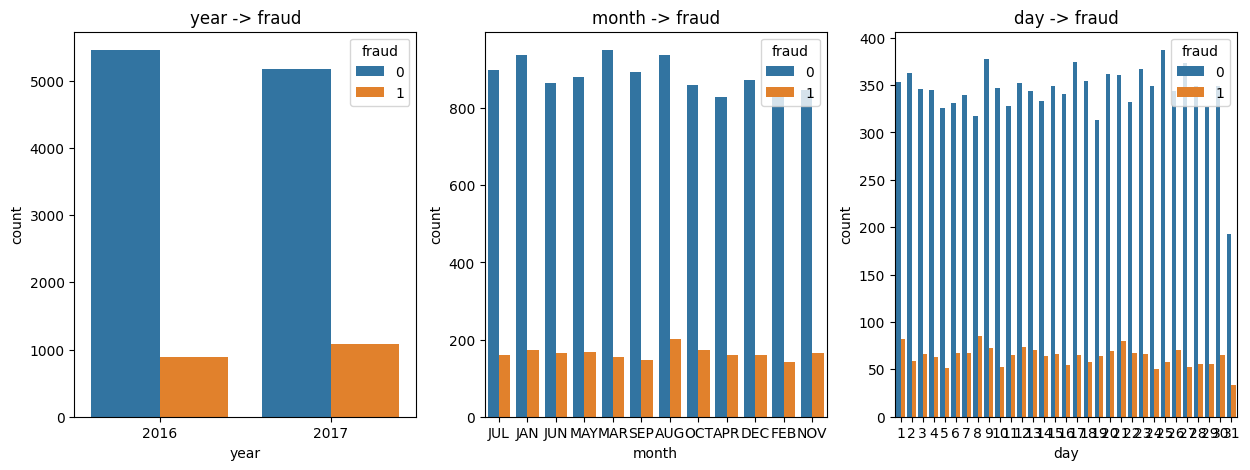

In [88]:
fig, axes = plt.subplots(1,3, figsize=(15,5))

sns.countplot(data=train, x='year', hue='fraud', ax=axes[0])
axes[0].set_title('year -> fraud')

sns.countplot(data=train, x='month', hue='fraud', ax=axes[1])
axes[1].set_title('month -> fraud')

sns.countplot(data=train, x='day', hue='fraud', ax=axes[2])
axes[2].set_title('day -> fraud')
# train = train.drop('month', axis=1)

자동차 색깔에 대한 보험 사기 여부도 시각화해보니 별 차이가 없어 보인다. -> 해당 피처도 제거

<Axes: xlabel='vehicle_color', ylabel='count'>

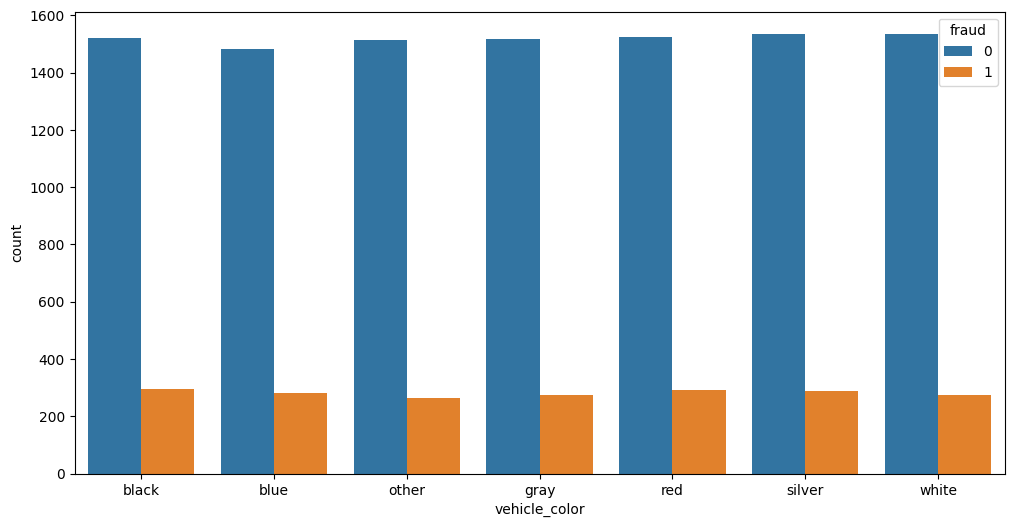

In [89]:
sns.countplot(data=train, x='vehicle_color', hue='fraud')

In [90]:
train = train.drop(['year', 'month', 'day', 'vehicle_color'], axis=1)

<Axes: >

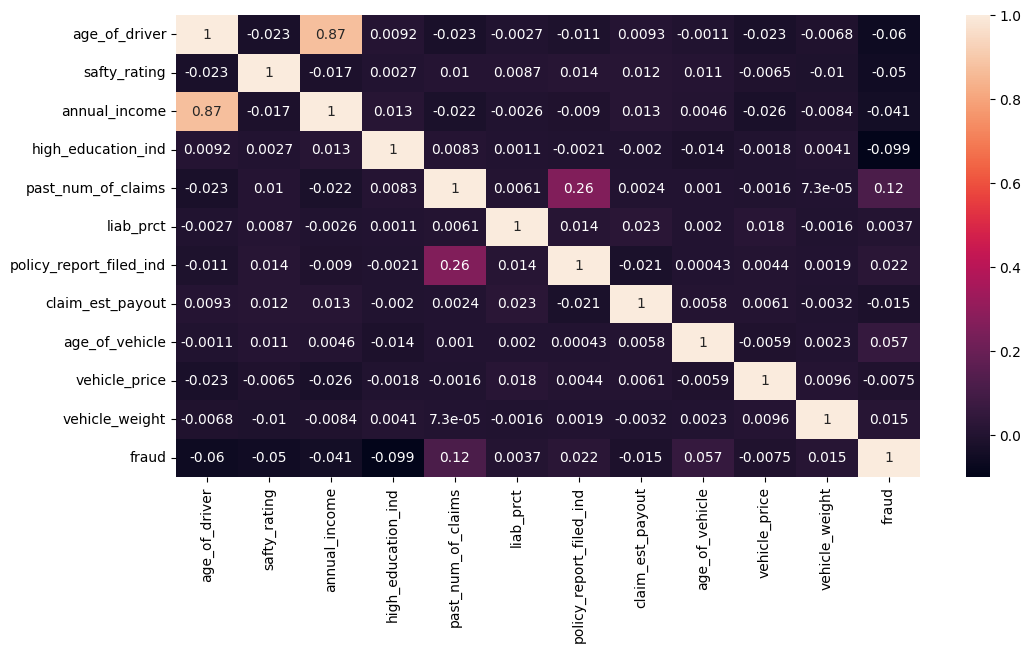

In [91]:
numeric_train = train.select_dtypes(include=['number'])

plt.rcParams['figure.figsize'] = [12,6]
sns.heatmap(numeric_train.corr(), annot=True)

원-핫 인코딩을 진행해보자.

In [110]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
object_train = train.select_dtypes(include=['object'])
object_train = object_train.drop(['ID', 'vehicle_category'], axis=1)

object_train_encoded = encoder.fit_transform(object_train).toarray()
object_train_columns = encoder.get_feature_names_out()

object_train_df = pd.DataFrame(object_train_encoded, columns=object_train_columns).astype(int)
object_train_df

,gender_Female,gender_Male,marital_status_Married,marital_status_Not married,marital_status_Unknown,address_change_ind_Changed,address_change_ind_Not changed,living_status_Own,living_status_Rent,claim_day_of_week_Friday,...,claim_day_of_week_Wednesday,accident_site_Highway,accident_site_Local,accident_site_Parking Lot,witness_present_ind_No witness,witness_present_ind_Unknown,witness_present_ind_Witness,channel_Broker,channel_Online,channel_Phone
0,0,1,1,0,0,1,0,1,0,0,...,0,0,1,0,1,0,0,1,0,0
1,1,0,1,0,0,1,0,1,0,0,...,0,0,1,0,1,0,0,0,0,1
2,0,1,0,1,0,0,1,0,1,0,...,0,0,1,0,1,0,0,0,1,0
3,0,1,1,0,0,1,0,0,1,0,...,0,1,0,0,1,0,0,1,0,0
4,0,1,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12593,0,1,1,0,0,1,0,0,1,0,...,0,0,0,1,1,0,0,0,0,1
12594,1,0,1,0,0,1,0,1,0,0,...,0,1,0,0,0,0,1,0,0,1
12595,1,0,1,0,0,0,1,1,0,0,...,0,0,1,0,1,0,0,0,0,1
12596,1,0,1,0,0,1,0,0,1,0,...,1,0,1,0,1,0,0,0,0,1
